# Big Dataset (6 month)

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1TWD3QDBrsn90zxbDom94BF4fR-NOp0Pi' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1TWD3QDBrsn90zxbDom94BF4fR-NOp0Pi" -O dataset_telecom.zip && rm -rf /tmp/cookies.txt
!unzip /content/dataset_telecom.zip

--2024-02-08 11:44:15--  https://docs.google.com/uc?export=download&confirm=&id=1TWD3QDBrsn90zxbDom94BF4fR-NOp0Pi
Resolving docs.google.com (docs.google.com)... 142.251.2.139, 142.251.2.101, 142.251.2.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1TWD3QDBrsn90zxbDom94BF4fR-NOp0Pi&export=download [following]
--2024-02-08 11:44:15--  https://drive.usercontent.google.com/download?id=1TWD3QDBrsn90zxbDom94BF4fR-NOp0Pi&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2451 (2.4K) [text/html]
Saving to: ‘dataset_telecom.zip’

dataset_telecom.zip 100%[===================>]   2.39K  --.-KB/s    in 0s      

In [ ]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict

def update_dic(df_id,file_path_id,columnSorting='start time'):
  dic_id=np.load(file_path_id,allow_pickle=True).item()
  for key in dic_id:
    dic_id[key]=np.append(dic_id[key],df_id[key].to_numpy())
  sorted_idx=dic_id[columnSorting].argsort()
  for key in dic_id:
    dic_id[key]=dic_id[key][sorted_idx]
  return dic_id

def update_dic(df_id,dataset_dic,id):
  dic_id=dataset_dic[id]
  for key in dic_id:
    dic_id[key]=np.append(dic_id[key],df_id[key].to_numpy())
  return dic_id

def sort_dic_id(dic_id,columnSorting='start time'):
  sorted_idx=dic_id[columnSorting].argsort()
  for key in dic_id:
    dic_id[key]=dic_id[key][sorted_idx]
  return dic_id

def create_dic(df_id,drop_column=['month','date','user id']):
  dic_id={}
  for name in df_id.columns:
    if name not in drop_column :
      dic_id[name]=df_id[name].to_numpy()
  return dic_id

def extract_data_in_dic(file_path,dataset_dic):
  df=pd.read_excel(file_path)
  os.makedirs('./TelecomDataset',exist_ok=True)
  grouped_id=df.groupby('user id')

  for id,df_id in grouped_id:

    if id in dataset_dic :
      dic_id=update_dic(df_id, dataset_dic,id)
    else:
      dic_id=create_dic(df_id)
    dic_id=sort_dic_id(dic_id,columnSorting='start time')
    dataset_dic[id]=dic_id
  return dataset_dic

def extract_data(file_path):
  df=pd.read_excel(file_path)
  os.makedirs('./TelecomDataset',exist_ok=True)
  grouped_id=df.groupby('user id')
  for id,df_id in grouped_id:
    file_path_id=os.path.join('.','TelecomDataset',id+'.npy')
    if os.path.isfile(file_path_id):
      dic_id=update_dic(df_id, file_path_id)
    else:
      dic_id=create_dic(df_id)
    np.save(file_path_id,dic_id)

dataset_dic={}
os.makedirs("TelecomDataset",exist_ok=True)
for file in os.listdir("."):

    if file.endswith(".xlsx"):
      print(file)
      dataset_dic= extract_data_in_dic(os.path.join(".", file),dataset_dic)
    np.save("./TelecomDataset/dataset_dic.npy",dataset_dic)




In [ ]:
def delete_overlaps_dataset(dataset_dic):
  for id in dataset_dic:
    dic_id=dataset_dic[id]
    dic_id=delete_overlaps_id(dic_id)
    dataset_dic[id]=dic_id
  return dataset_dic

def delete_overlaps_id(dic_id):
  for i in range(len(dic_id['start time'])-1):
    if dic_id['start time'][i+1]<dic_id['end time'][i]:
      dic_id['end time'][i]=dic_id['start time'][i+1]
  return dic_id

def convervt_id_to_idx(dataset_dic):
  dataset_dic_idx={}
  list_id=[]
  for idx,id in enumerate(dataset_dic):
    dataset_dic_idx[idx]=dataset_dic[id]
    list_id.append(id)

  return dataset_dic_idx, list_id
def get_dic_station(dataset_dic):
  dic_station={}
  list_station=[]
  for i in dataset_dic:

    latitudes=dataset_dic[i]["latitude"]
    longitudes=dataset_dic[i]["longitude"]
    for position in zip(latitudes,longitudes):
      if np.isnan(position[0]):
        position=(np.float64(-1),position[1])
      if np.isnan(position[1]):
        position=(position[0],np.float64(-1))
      if position in dic_station:
        dic_station[position]["number"]+=1
      else:
        dic_station[position]={}
        dic_station[position]["number"]=1
        list_station.append(position)
        dic_station[position]["idx"]=len(list_station)-1

  return dic_station, list_station
def add_class(dataset_dic,dic_station):
  for idx in dataset_dic:
    latitudes=dataset_dic[idx]["latitude"]
    longitudes=dataset_dic[idx]["longitude"]
    for position in zip(latitudes,longitudes):
      if np.isnan(position[0]):
          position=(np.float64(-1),position[1])
      if np.isnan(position[1]):
          position=(position[0],np.float64(-1))
      dataset_dic[idx]["class"]=dic_station[position]["idx"]
  return dataset_dic

def get_mean_connect_time(dataset_dic):
  total_nb=0
  sum=0
  for idx in dataset_dic:
    start_times=dataset_dic[idx]["start time"]
    end_times=dataset_dic[idx]["end time"]
    total_nb+=len(start_times)
    sum+=(end_times-start_times).sum().astype('timedelta64[s]')

  return sum/total_nb




# Small Dataset (15 days)

In [3]:
!wget http://sguangwang.com/dataset/telecom.zip
!unzip /content/telecom.zip

--2024-02-14 12:59:00--  http://sguangwang.com/dataset/telecom.zip
Resolving sguangwang.com (sguangwang.com)... 182.50.151.114
Connecting to sguangwang.com (sguangwang.com)|182.50.151.114|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53432897 (51M) [application/x-zip-compressed]
Saving to: ‘telecom.zip’

telecom.zip         100%[===================>]  50.96M  15.3MB/s    in 4.3s    

2024-02-14 12:59:05 (11.9 MB/s) - ‘telecom.zip’ saved [53432897/53432897]

Archive:  /content/telecom.zip
  inflating: dataset-telecom/data_6.1~6.30_.xlsx  


## Prediction

### Prepocessing

In [4]:
import pandas
import torch
import numpy as np
df=pandas.read_excel("/content/dataset-telecom/data_6.1~6.30_.xlsx")
df


,month,date,start time,end time,location(latitude/lontitude),user id
0,201406,1,2014-06-01 10:22:36,2014-06-01 11:09:52,31.237872/121.470259,edbc54bddf16494a49f39ac057b4185d
1,201406,1,2014-06-01 07:00:37,2014-06-01 08:49:20,31.237872/121.470259,f8206ab58b9bdb070673f7050242e9ee
2,201406,1,2014-06-01 02:49:16,2014-06-01 05:49:12,31.237872/121.470259,f8206ab58b9bdb070673f7050242e9ee
3,201406,1,2014-06-01 08:51:58,2014-06-01 09:20:50,31.237872/121.470259,f8206ab58b9bdb070673f7050242e9ee
4,201406,1,2014-05-31 23:49:10,2014-06-01 02:49:07,31.237872/121.470259,f8206ab58b9bdb070673f7050242e9ee
...,...,...,...,...,...,...
611501,201406,15,2014-06-15 06:28:05,2014-06-15 06:28:23,NaN,c9bb8d82dac3acd0035bb214503ad3dc
611502,201406,15,2014-06-15 23:00:03,2014-06-15 23:10:02,NaN,c9bb8d82dac3acd0035bb214503ad3dc
611503,201406,15,2014-06-15 14:10:36,2014-06-15 17:06:36,NaN,f3533f216dfc72a23bba26c4e3f0247c
611504,201406,15,2014-06-15 14:10:35,2014-06-15 17:10:31,NaN,f3533f216dfc72a23bba26c4e3f0247c


In [5]:
df=df.sort_values('start time')
df

,month,date,start time,end time,location(latitude/lontitude),user id
28655,201406,1,2014-05-31 23:00:00,2014-06-01 00:46:33,30.935314/121.733322,087bd62a377feb26dbe0d98bb1a39285
6116,201406,1,2014-05-31 23:00:00,2014-06-01 01:26:12,31.144812/121.119606,5ffe3821c24673d3440e8f58da37508b
14175,201406,1,2014-05-31 23:00:00,2014-05-31 23:37:03,31.381763/121.301878,10f91d74831291ec42de621b777b0575
7665,201406,1,2014-05-31 23:00:00,2014-06-01 00:02:10,31.056648/121.404326,a79a4895f1ca2f0c8f2052236b4f29b5
31709,201406,1,2014-05-31 23:00:00,2014-06-01 01:17:34,31.100034/121.663489,1f44297aaa9a8010dfcf8dd743f47c04
...,...,...,...,...,...,...
572071,201406,15,2014-06-15 23:55:11,2014-06-15 23:55:11,31.232548/121.478971,f03125c666c4dbe2b4ede13b5cec8970
572086,201406,15,2014-06-15 23:55:23,2014-06-15 23:57:15,31.227933/121.45361,f03125c666c4dbe2b4ede13b5cec8970
609614,201406,15,2014-06-15 23:55:37,2014-06-15 23:55:48,NaN,2605b08b9e744f5bd8c719a4ba75cc6c
594975,201406,15,2014-06-15 23:57:44,2014-06-15 23:58:17,31.21852/121.44019,f03125c666c4dbe2b4ede13b5cec8970


In [6]:

def get_x(value):
    if isinstance(value, str):
        return float(value.split("/")[0])
    elif isinstance(value, float):
        return value
def get_y(value):
    if isinstance(value, str):
        return float(value.split("/")[1])
    elif isinstance(value, float):
        return value

df['x'] = df['location(latitude/lontitude)'].apply(get_x)
df['y'] = df['location(latitude/lontitude)'].apply(get_y)
df['x_normalised']=(df['x']-df['x'].mean())/(df['x'].std())
df['y_normalised']=(df['y']-df['y'].mean())/df['y'].std()
df['pos']= list(zip(df['x'],df['y']))
df

,month,date,start time,end time,location(latitude/lontitude),user id,x,y,x_normalised,y_normalised,pos
28655,201406,1,2014-05-31 23:00:00,2014-06-01 00:46:33,30.935314/121.733322,087bd62a377feb26dbe0d98bb1a39285,30.935314,121.733322,-0.383140,0.317890,"(30.935314, 121.733322)"
6116,201406,1,2014-05-31 23:00:00,2014-06-01 01:26:12,31.144812/121.119606,5ffe3821c24673d3440e8f58da37508b,31.144812,121.119606,-0.077538,-0.158312,"(31.144812, 121.119606)"
14175,201406,1,2014-05-31 23:00:00,2014-05-31 23:37:03,31.381763/121.301878,10f91d74831291ec42de621b777b0575,31.381763,121.301878,0.268111,-0.016882,"(31.381763, 121.301878)"
7665,201406,1,2014-05-31 23:00:00,2014-06-01 00:02:10,31.056648/121.404326,a79a4895f1ca2f0c8f2052236b4f29b5,31.056648,121.404326,-0.206146,0.062611,"(31.056648, 121.404326)"
31709,201406,1,2014-05-31 23:00:00,2014-06-01 01:17:34,31.100034/121.663489,1f44297aaa9a8010dfcf8dd743f47c04,31.100034,121.663489,-0.142857,0.263704,"(31.100034, 121.663489)"
...,...,...,...,...,...,...,...,...,...,...,...
572071,201406,15,2014-06-15 23:55:11,2014-06-15 23:55:11,31.232548/121.478971,f03125c666c4dbe2b4ede13b5cec8970,31.232548,121.478971,0.050446,0.120531,"(31.232548, 121.478971)"
572086,201406,15,2014-06-15 23:55:23,2014-06-15 23:57:15,31.227933/121.45361,f03125c666c4dbe2b4ede13b5cec8970,31.227933,121.453610,0.043714,0.100852,"(31.227933, 121.45361)"
609614,201406,15,2014-06-15 23:55:37,2014-06-15 23:55:48,NaN,2605b08b9e744f5bd8c719a4ba75cc6c,NaN,NaN,NaN,NaN,"(nan, nan)"
594975,201406,15,2014-06-15 23:57:44,2014-06-15 23:58:17,31.21852/121.44019,f03125c666c4dbe2b4ede13b5cec8970,31.218520,121.440190,0.029982,0.090439,"(31.21852, 121.44019)"


In [7]:

import math

#unique position
pos=df['pos'].unique()
vocab=dict(zip(pos,range(len(pos))))
vocab[(float('nan'),float('nan'))]=len(vocab)

def tokenize_pos(pos):
  if math.isnan(pos[0]) and math.isnan(pos[1]):
    return len(vocab)
  else:
    return vocab[pos]
df['pos_id'] = df['pos'].apply(tokenize_pos)
df


,month,date,start time,end time,location(latitude/lontitude),user id,x,y,x_normalised,y_normalised,pos,pos_id
28655,201406,1,2014-05-31 23:00:00,2014-06-01 00:46:33,30.935314/121.733322,087bd62a377feb26dbe0d98bb1a39285,30.935314,121.733322,-0.383140,0.317890,"(30.935314, 121.733322)",0
6116,201406,1,2014-05-31 23:00:00,2014-06-01 01:26:12,31.144812/121.119606,5ffe3821c24673d3440e8f58da37508b,31.144812,121.119606,-0.077538,-0.158312,"(31.144812, 121.119606)",1
14175,201406,1,2014-05-31 23:00:00,2014-05-31 23:37:03,31.381763/121.301878,10f91d74831291ec42de621b777b0575,31.381763,121.301878,0.268111,-0.016882,"(31.381763, 121.301878)",2
7665,201406,1,2014-05-31 23:00:00,2014-06-01 00:02:10,31.056648/121.404326,a79a4895f1ca2f0c8f2052236b4f29b5,31.056648,121.404326,-0.206146,0.062611,"(31.056648, 121.404326)",3
31709,201406,1,2014-05-31 23:00:00,2014-06-01 01:17:34,31.100034/121.663489,1f44297aaa9a8010dfcf8dd743f47c04,31.100034,121.663489,-0.142857,0.263704,"(31.100034, 121.663489)",4
...,...,...,...,...,...,...,...,...,...,...,...,...
572071,201406,15,2014-06-15 23:55:11,2014-06-15 23:55:11,31.232548/121.478971,f03125c666c4dbe2b4ede13b5cec8970,31.232548,121.478971,0.050446,0.120531,"(31.232548, 121.478971)",2688
572086,201406,15,2014-06-15 23:55:23,2014-06-15 23:57:15,31.227933/121.45361,f03125c666c4dbe2b4ede13b5cec8970,31.227933,121.453610,0.043714,0.100852,"(31.227933, 121.45361)",692
609614,201406,15,2014-06-15 23:55:37,2014-06-15 23:55:48,NaN,2605b08b9e744f5bd8c719a4ba75cc6c,NaN,NaN,NaN,NaN,"(nan, nan)",2771
594975,201406,15,2014-06-15 23:57:44,2014-06-15 23:58:17,31.21852/121.44019,f03125c666c4dbe2b4ede13b5cec8970,31.218520,121.440190,0.029982,0.090439,"(31.21852, 121.44019)",1437


In [8]:
#create encoded time series
min_year = df["start time"].dt.year.min()
max_year = df["start time"].dt.year.max()
  #normalize years in range 0 to 1
df['year_normalised'] = (df["start time"].dt.year - min_year) / (max_year - min_year)

  #compute trigonometric components for months, days, hours, minutes and seconds
df['month_sin'] = np.sin(2 * np.pi * df["start time"].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df["start time"].dt.month / 12)

df['day_sin'] = np.sin(2 * np.pi * df["start time"].dt.day / 31)
df['day_cos'] = np.cos(2 * np.pi * df["start time"].dt.day / 31)

df['hour_sin'] = np.sin(2 * np.pi * df["start time"].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df["start time"].dt.hour / 24)

df['minute_sin'] = np.sin(2 * np.pi * df["start time"].dt.minute / 60)
df['minute_cos'] = np.cos(2 * np.pi * df["start time"].dt.minute / 60)

df['second_sin'] = np.sin(2 * np.pi * df["start time"].dt.second / 60)
df['second_cos'] = np.cos(2 * np.pi * df["start time"].dt.second / 60)

df['time_to_end']=df['end time']-df['start time']
df['time_to_end']=df['time_to_end'].dt.total_seconds()

df

,month,date,start time,end time,location(latitude/lontitude),user id,x,y,x_normalised,y_normalised,...,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,time_to_end
28655,201406,1,2014-05-31 23:00:00,2014-06-01 00:46:33,30.935314/121.733322,087bd62a377feb26dbe0d98bb1a39285,30.935314,121.733322,-0.383140,0.317890,...,-0.866025,-2.449294e-16,1.000000,-0.258819,0.965926,0.000000,1.000000,0.000000,1.000000,6393.0
6116,201406,1,2014-05-31 23:00:00,2014-06-01 01:26:12,31.144812/121.119606,5ffe3821c24673d3440e8f58da37508b,31.144812,121.119606,-0.077538,-0.158312,...,-0.866025,-2.449294e-16,1.000000,-0.258819,0.965926,0.000000,1.000000,0.000000,1.000000,8772.0
14175,201406,1,2014-05-31 23:00:00,2014-05-31 23:37:03,31.381763/121.301878,10f91d74831291ec42de621b777b0575,31.381763,121.301878,0.268111,-0.016882,...,-0.866025,-2.449294e-16,1.000000,-0.258819,0.965926,0.000000,1.000000,0.000000,1.000000,2223.0
7665,201406,1,2014-05-31 23:00:00,2014-06-01 00:02:10,31.056648/121.404326,a79a4895f1ca2f0c8f2052236b4f29b5,31.056648,121.404326,-0.206146,0.062611,...,-0.866025,-2.449294e-16,1.000000,-0.258819,0.965926,0.000000,1.000000,0.000000,1.000000,3730.0
31709,201406,1,2014-05-31 23:00:00,2014-06-01 01:17:34,31.100034/121.663489,1f44297aaa9a8010dfcf8dd743f47c04,31.100034,121.663489,-0.142857,0.263704,...,-0.866025,-2.449294e-16,1.000000,-0.258819,0.965926,0.000000,1.000000,0.000000,1.000000,8254.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572071,201406,15,2014-06-15 23:55:11,2014-06-15 23:55:11,31.232548/121.478971,f03125c666c4dbe2b4ede13b5cec8970,31.232548,121.478971,0.050446,0.120531,...,-1.000000,1.011683e-01,-0.994869,-0.258819,0.965926,-0.500000,0.866025,0.913545,0.406737,0.0
572086,201406,15,2014-06-15 23:55:23,2014-06-15 23:57:15,31.227933/121.45361,f03125c666c4dbe2b4ede13b5cec8970,31.227933,121.453610,0.043714,0.100852,...,-1.000000,1.011683e-01,-0.994869,-0.258819,0.965926,-0.500000,0.866025,0.669131,-0.743145,112.0
609614,201406,15,2014-06-15 23:55:37,2014-06-15 23:55:48,NaN,2605b08b9e744f5bd8c719a4ba75cc6c,NaN,NaN,NaN,NaN,...,-1.000000,1.011683e-01,-0.994869,-0.258819,0.965926,-0.500000,0.866025,-0.669131,-0.743145,11.0
594975,201406,15,2014-06-15 23:57:44,2014-06-15 23:58:17,31.21852/121.44019,f03125c666c4dbe2b4ede13b5cec8970,31.218520,121.440190,0.029982,0.090439,...,-1.000000,1.011683e-01,-0.994869,-0.258819,0.965926,-0.309017,0.951057,-0.994522,-0.104528,33.0


In [9]:
df=df.drop(['month', 'date', 'end time', 'location(latitude/lontitude)', 'x', 'y','pos'], axis=1)
df

,start time,user id,x_normalised,y_normalised,pos_id,year_normalised,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,time_to_end
28655,2014-05-31 23:00:00,087bd62a377feb26dbe0d98bb1a39285,-0.383140,0.317890,0,NaN,5.000000e-01,-0.866025,-2.449294e-16,1.000000,-0.258819,0.965926,0.000000,1.000000,0.000000,1.000000,6393.0
6116,2014-05-31 23:00:00,5ffe3821c24673d3440e8f58da37508b,-0.077538,-0.158312,1,NaN,5.000000e-01,-0.866025,-2.449294e-16,1.000000,-0.258819,0.965926,0.000000,1.000000,0.000000,1.000000,8772.0
14175,2014-05-31 23:00:00,10f91d74831291ec42de621b777b0575,0.268111,-0.016882,2,NaN,5.000000e-01,-0.866025,-2.449294e-16,1.000000,-0.258819,0.965926,0.000000,1.000000,0.000000,1.000000,2223.0
7665,2014-05-31 23:00:00,a79a4895f1ca2f0c8f2052236b4f29b5,-0.206146,0.062611,3,NaN,5.000000e-01,-0.866025,-2.449294e-16,1.000000,-0.258819,0.965926,0.000000,1.000000,0.000000,1.000000,3730.0
31709,2014-05-31 23:00:00,1f44297aaa9a8010dfcf8dd743f47c04,-0.142857,0.263704,4,NaN,5.000000e-01,-0.866025,-2.449294e-16,1.000000,-0.258819,0.965926,0.000000,1.000000,0.000000,1.000000,8254.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572071,2014-06-15 23:55:11,f03125c666c4dbe2b4ede13b5cec8970,0.050446,0.120531,2688,NaN,1.224647e-16,-1.000000,1.011683e-01,-0.994869,-0.258819,0.965926,-0.500000,0.866025,0.913545,0.406737,0.0
572086,2014-06-15 23:55:23,f03125c666c4dbe2b4ede13b5cec8970,0.043714,0.100852,692,NaN,1.224647e-16,-1.000000,1.011683e-01,-0.994869,-0.258819,0.965926,-0.500000,0.866025,0.669131,-0.743145,112.0
609614,2014-06-15 23:55:37,2605b08b9e744f5bd8c719a4ba75cc6c,NaN,NaN,2771,NaN,1.224647e-16,-1.000000,1.011683e-01,-0.994869,-0.258819,0.965926,-0.500000,0.866025,-0.669131,-0.743145,11.0
594975,2014-06-15 23:57:44,f03125c666c4dbe2b4ede13b5cec8970,0.029982,0.090439,1437,NaN,1.224647e-16,-1.000000,1.011683e-01,-0.994869,-0.258819,0.965926,-0.309017,0.951057,-0.994522,-0.104528,33.0


In [10]:
df_user_group = df.groupby('user id')
df_user_group

In [11]:

list_users=[]
for user, df_user in df_user_group:
  if len(df_user)>=2:
    df_user["time_to_next"] =  df_user["start time"].diff(-1).dt.total_seconds()
    dict_user=df_user.to_dict('list')
    dict_user["time_to_next"][-1]=-1.
    dict_user["pos_id"]=torch.tensor(dict_user["pos_id"]+[len(vocab)+1])

    dict_user["pos_id_target"]=dict_user["pos_id"][1:]
    dict_user["pos_id"]=dict_user["pos_id"][:-1]

    #Choice of inputs for the model: x_normalised, y_normalised, month_sin, month_cos, day_sin, day_cos, hour_sin, hour_cos, minute_sin, minute_cos, second_sin, second_cos
    dict_user["input"]=torch.tensor([dict_user["x_normalised"],dict_user["y_normalised"],dict_user['month_sin'], dict_user['month_cos'], dict_user['day_sin'], dict_user['day_cos'], dict_user['hour_sin'], dict_user['hour_cos'], dict_user['minute_sin'], dict_user['minute_cos'], dict_user['second_sin'], dict_user['second_cos']]).T
    #print(dict_user["input"].shape,dict_user["input"].T.shape)

    #choice of outputs for the model: time_to_end, time_to_next corresponding to the remaining time until the end of the call and time until the next call
    dict_user["time_target"]=torch.tensor([dict_user["time_to_end"],dict_user["time_to_next"]]).T
    j=1
    i=0
    while i < dict_user["input"].size(0) and torch.isnan(dict_user["input"][i,j]):
      i+=1
    if i < dict_user["input"].size(0):
      dict_user["input"][:i,0]=dict_user["input"][i,0]
      dict_user["input"][:i,1]=dict_user["input"][i,1]
      nan_positions = torch.isnan(dict_user["input"])
      # Step 2: Replace NaN values with the values from the preceding row of the same column
      for i in range(i+1, dict_user["input"].size(0)):
        dict_user["input"][i, nan_positions[i]] = dict_user["input"][i - 1, nan_positions[i]]

      for e in ['x_normalised', 'y_normalised','year_normalised', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos', 'time_to_end', 'time_to_next']:
        dict_user.pop(e)
      list_users.append(dict_user)

In [12]:
# list_users[0]

In [12]:
# list_users[0].keys()

In [11]:
all_keys = dict_user.keys()
for key in all_keys:
  print( key + " : " + str(len(dict_user[key])))

start time : 259
user id : 259
pos_id : 259
pos_id_target : 259
input : 259
time_target : 259


In [13]:
#Count all inputs and outputs
count = 0
for user in list_users:
  count += user["input"].size(0)
count

604857

In [ ]:
torch.tensor([2,3,4])[:-1]

tensor([2, 3])

### Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
class VariableLengthDataset(Dataset):
    def __init__(self, time_series, transform=None):
        self.times_series=time_series

    def __len__(self):
        return len(self.times_series)

    def __getitem__(self, idx):
        user_dict=self.times_series[idx]

        return  user_dict['input'],user_dict['pos_id_target'], user_dict['time_target']

dataset=VariableLengthDataset(list_users)

In [ ]:
dataset.__getitem__(0)[0].shape

torch.Size([14, 12])

In [ ]:
import torch
def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''
    ## get sequence lengths
    inputs,pos_ids,time_targets=zip(*batch)
    lengths = torch.tensor([ input.shape[0] for input in inputs ])
    inputs = torch.nn.utils.rnn.pad_sequence(inputs,batch_first=True,padding_value=0)
    time_targets = torch.nn.utils.rnn.pad_sequence(time_targets,batch_first=True,padding_value=-1)
    pos_ids = torch.nn.utils.rnn.pad_sequence(pos_ids,batch_first=True,padding_value=len(vocab))

    ## compute mask
    mask_time_targets = (time_targets != -1)
    return inputs, time_targets, pos_ids, lengths, mask_time_targets
dataloader=DataLoader(dataset,batch_size=64,collate_fn=collate_fn_padd,shuffle=True)

In [ ]:
next(iter(dataloader))

(tensor([[[-5.9231e-02, -7.9177e-02,  1.2246e-16,  ...,  5.0000e-01,
            9.9452e-01,  1.0453e-01],
          [-5.8977e-02, -9.3343e-02,  1.2246e-16,  ...,  8.0902e-01,
           -9.1355e-01, -4.0674e-01],
          [-5.8977e-02, -9.3343e-02,  1.2246e-16,  ..., -5.8779e-01,
            5.8779e-01, -8.0902e-01],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[-8.6934e-02,  7.2426e-02,  1.2246e-16,  ..., -4.0674e-01,
            1.0453e-01, -9.9452e-01],
          [-8.6934e-02,  7.2426e-02,  1.2246e-16,  ..., -6.6913e-01,
            9.1355e-01, -4.0674e-01],
          [-8.6934e-02,  7.2426e-02,  1.2246e-16,  ..., -7.4314e-01,
            3.0902e-01,  9.5106e-01],
          ...,
    

### Classic Training


In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.nn import Embedding, LSTM
import torch.nn.functional as F
from torch import autocast
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
epochs=17
encoder=LSTM(input_size=12, hidden_size=len(vocab)+4,batch_first=True,num_layers=2).cuda()
optimizer_encoder = optim.Adam(encoder.parameters())
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
train_losses=[]
for epoch in range(epochs):
  epoch_losses=[]
  for inputs, time_targets, pos_ids, lengths, mask_time_targets in dataloader:
    optimizer_encoder.zero_grad()
    inputs=inputs.float().cuda()
    time_targets = time_targets.cuda()
    pos_ids = pos_ids.cuda()
    mask_time_targets = mask_time_targets.cuda()
    packed_batch=torch.nn.utils.rnn.pack_padded_sequence(inputs, lengths=lengths,batch_first=True, enforce_sorted=False)
    with autocast(device_type="cuda"):
      packed_output,(ht, ct)=encoder(packed_batch)
      output, input_sizes = pad_packed_sequence(packed_output,batch_first=True)
      loss_classification=criterion_classification(output[:,:,:len(vocab)+2].transpose(1,2),pos_ids)
      loss_regression=criterion_regression(F.relu(output[:,:,len(vocab)+2:]),time_targets)
      loss_regression = (loss_regression * mask_time_targets.float()).mean()
      loss=loss_classification+1e-7*loss_regression
    loss.backward()
    optimizer_encoder.step()
    epoch_losses.append(loss.cpu().item())
  loss_epoch=np.mean(epoch_losses)
  print("epoch: "+str(epoch)+" loss: "+str(loss_epoch))
  train_losses.append(loss_epoch)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

### Sequencing Classification and regression

In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.nn import Embedding, LSTM
import torch.nn.functional as F
from torch import autocast
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
epochs_classifcation_only=10
epochs_complete_problem =10
lr=0.001
epochs=epochs_complete_problem+ epochs_classifcation_only
encoder=LSTM(input_size=12, hidden_size=len(vocab)+4,batch_first=True,num_layers=2).cuda()
optimizer_encoder = optim.Adam(encoder.parameters(),lr=lr)
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
train_losses=[]
for epoch in range(epochs):
  epoch_losses=[]
  for inputs, time_targets, pos_ids, lengths, mask_time_targets in dataloader:
    optimizer_encoder.zero_grad()
    inputs=inputs.float().cuda()
    time_targets = time_targets.cuda()
    pos_ids = pos_ids.cuda()
    mask_time_targets = mask_time_targets.cuda()
    packed_batch=torch.nn.utils.rnn.pack_padded_sequence(inputs, lengths=lengths,batch_first=True, enforce_sorted=False)
    with autocast(device_type="cuda"):
      packed_output,(ht, ct)=encoder(packed_batch)
      output, input_sizes = pad_packed_sequence(packed_output,batch_first=True)
      loss_classification=criterion_classification(output[:,:,:len(vocab)+2].transpose(1,2),pos_ids)
      if epoch>=epochs_classifcation_only:
        loss_regression=criterion_regression(F.relu(output[:,:,len(vocab)+2:]),time_targets)
        loss_regression = (loss_regression * mask_time_targets.float()).mean()
        loss=loss_classification+1e-7*loss_regression
      else:
        loss=loss_classification
    loss.backward()
    optimizer_encoder.step()
    epoch_losses.append(loss.cpu().item())
  loss_epoch=np.mean(epoch_losses)
  print("epoch: "+str(epoch)+" loss: "+str(loss_epoch))
  train_losses.append(loss_epoch)

epoch: 0 loss: 7.769814189275106
epoch: 1 loss: 7.688149589962429
epoch: 2 loss: 7.681943141089546
epoch: 3 loss: 7.677431223127577
epoch: 4 loss: 7.672929933336046
epoch: 5 loss: 7.673284302817451
epoch: 6 loss: 7.6768125428093805
epoch: 7 loss: 7.67123220761617
epoch: 8 loss: 7.660207096735636
epoch: 9 loss: 7.653950717714098
epoch: 10 loss: 18.43856125937568
epoch: 11 loss: 18.592761262257895
epoch: 12 loss: 18.74313888549805
epoch: 13 loss: 18.691165171729192
epoch: 14 loss: 18.619252024756538
epoch: 15 loss: 18.730495770772297
epoch: 16 loss: 18.771625094943577
epoch: 17 loss: 18.628106456332738
epoch: 18 loss: 18.654819912380642
epoch: 19 loss: 18.703358374701605


### Modified architecture

In [ ]:
class LSTM_Classification_regression(nn.Module):
  def __init__(self, input_size, hidden_size,output_regression_size,output_classfication_size,num_layers,batch_first=True):
    super().__init__(self)
    self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size,batch_first=batch_first,num_layers=2)
    self.linear_reg=nn.Linear(hidden_size,output_regression_size)
    self.classifier=nn.Linear(hidden_size,output_classfication_size)
  def forward(self,x,reg=True):
    x,_=self.lstm(x)
    x=F.relu(x)
    if reg:
      return self.classifier(x),self.linear_reg(x)
    else:
      return self.classifier(x)



In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.nn import Embedding, LSTM
import torch.nn.functional as F
from torch import autocast
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
epochs_classifcation_only=10
epochs_complete_problem =10
input_size=12
hidden_size=len(vocab)+4
output_regression_size=2
output_classfication_size=hidden_size-output_regression_size
epochs=epochs_complete_problem+ epochs_classifcation_only
model=LSTM_Classification_regression(input_size, hidden_size,output_regression_size,output_classfication_size,num_layers).cuda()

optimizer_encoder = optim.Adam(encoder.parameters())

criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')

train_losses=[]
for epoch in range(epochs):
  epoch_losses=[]
  for x, time_targets, pos_ids, lengths, mask_time_targets in dataloader:
    batch_size=x.shape[0]
    optimizer_encoder.zero_grad()
    inputs=inputs.float().cuda()
    time_targets = time_targets.cuda()
    pos_ids = pos_ids.cuda()
    mask_time_targets = mask_time_targets.cuda()
    x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths,batch_first=True, enforce_sorted=False)
    with autocast(device_type="cuda"):
      if epoch<epochs_classifcation_only:
        x=model(x,reg=False)
        x=pad_packed_sequence(torch.nn.utils.rnn.PackedSequence(out, batch_size), batch_first=True)
        loss=criterion_classification(x.transpose(1,2),pos_ids)
      else:
        x,y=model(x,reg=True)
        loss_classification=criterion_classification(x.transpose(1,2),pos_ids)
        loss_regression=criterion_regression(F.relu(y),time_targets)
        loss_regression = (loss_regression * mask_time_targets.float()).mean()
        loss=loss_classification+1e-7*loss_regression
    loss.backward()
    optimizer_encoder.step()
    epoch_losses.append(loss.cpu().item())
  loss_epoch=np.mean(epoch_losses)
  print("epoch: "+str(epoch)+" loss: "+str(loss_epoch))
  train_losses.append(loss_epoch)

### Embeddings


#### New Dataset with  current pos_id

In [ ]:
from torch.utils.data import Dataset, DataLoader
class VariableLengthDatasetWithPosID(Dataset):
    def __init__(self, time_series, transform=None):
        self.times_series=time_series

    def __len__(self):
        return len(self.times_series)

    def __getitem__(self, idx):
        user_dict=self.times_series[idx]

        return  user_dict['input'],user_dict['pos_id'],user_dict['pos_id_target'], user_dict['time_target']

dataset=VariableLengthDatasetWithPosID(list_users)

In [ ]:
import torch
def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''
    ## get sequence lengths
    inputs,pos_ids,pos_id_targets,time_targets=zip(*batch)
    lengths = torch.tensor([ input.shape[0] for input in inputs ])
    inputs = torch.nn.utils.rnn.pad_sequence(inputs,batch_first=True,padding_value=0)
    time_targets = torch.nn.utils.rnn.pad_sequence(time_targets,batch_first=True,padding_value=-1)
    pos_ids = torch.nn.utils.rnn.pad_sequence(pos_ids,batch_first=True,padding_value=len(vocab))
    pos_id_targets = torch.nn.utils.rnn.pad_sequence(pos_id_targets,batch_first=True,padding_value=len(vocab))

    ## compute mask
    mask_time_targets = (time_targets != -1)
    return inputs, pos_ids, time_targets, pos_id_targets, lengths, mask_time_targets
dataloader=DataLoader(dataset,batch_size=64,collate_fn=collate_fn_padd,shuffle=True)

#### Modified Model with embeddings

In [ ]:
torch.nn.utils.rnn.pack_padded_sequence(torch.tensor([[2,3,0],[2,3,3]]),lengths=[2,3],batch_first=True,enforce_sorted=False)

PackedSequence(data=tensor([2, 2, 3, 3, 3]), batch_sizes=tensor([2, 2, 1]), sorted_indices=tensor([1, 0]), unsorted_indices=tensor([1, 0]))

In [ ]:
import torch.nn as nn
import torch
from torch.nn import Embedding, LSTM
import torch.nn.functional as F

class LSTM_Classification_regression_Embeddings(nn.Module):
  def __init__(self, input_size, hidden_size,output_regression_size,output_classfication_size,embedding_dim,num_layers,batch_first=True):
    super().__init__()
    self.lstm = LSTM(input_size=input_size+embedding_dim, hidden_size=hidden_size,batch_first=batch_first,num_layers=2)
    self.linear_reg=nn.Linear(hidden_size,output_regression_size)
    self.classifier=nn.Linear(hidden_size,output_classfication_size)
    self.embeddings=nn.Embedding(num_embeddings=output_classfication_size,embedding_dim=embedding_dim)


  def forward(self,x,pos_id,reg=True):
    x=torch.cat([x,self.embeddings(pos_id)],dim=2)
    x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths,batch_first=True, enforce_sorted=False)
    x,_=self.lstm(x)
    x=torch.nn.utils.rnn.PackedSequence(F.relu(x.data), x.batch_sizes, x.sorted_indices, x.unsorted_indices)
    if reg:
      data = x.data
      x = torch.nn.utils.rnn.PackedSequence(self.classifier(data), x.batch_sizes, x.sorted_indices, x.unsorted_indices)
      y = torch.nn.utils.rnn.PackedSequence(self.classifier(x.data), x.batch_sizes, x.sorted_indices, x.unsorted_indices)
      return x,y
    else:
      return  torch.nn.utils.rnn.PackedSequence(self.classifier(x.data), x.batch_sizes, x.sorted_indices, x.unsorted_indices)

In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.nn import Embedding, LSTM
import torch.nn.functional as F
from torch import autocast
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
## parameters
#training params
epochs_classifcation_only=10
epochs_complete_problem =10
epochs=epochs_complete_problem+ epochs_classifcation_only
#Model params
input_size=12
embedding_dim=100
num_layers=2
hidden_size=len(vocab)+4
output_regression_size=2
output_classfication_size=hidden_size-output_regression_size

model=LSTM_Classification_regression_Embeddings(input_size, hidden_size,output_regression_size,output_classfication_size,embedding_dim,num_layers).cuda()
optimizer_encoder = optim.Adam(model.parameters())

criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')

train_losses=[]
for epoch in range(epochs):
  epoch_losses=[]
  for x, pos_ids, time_targets, target_pos_ids, lengths, mask_time_targets in dataloader:
    batch_size=x.shape[0]
    optimizer_encoder.zero_grad()
    x=x.float().cuda()
    pos_ids=pos_ids.cuda()
    time_targets = time_targets.cuda()
    #print(target_pos_ids)
    target_pos_ids = target_pos_ids.cuda()
    mask_time_targets = mask_time_targets.cuda()
    with autocast(device_type="cuda"):
      if epoch<epochs_classifcation_only:
        x=model(x,pos_ids,reg=False)
        x, input_sizes=pad_packed_sequence(x, batch_first=True)
        loss=criterion_classification(x.transpose(1,2),target_pos_ids)
      else:
        x,y=model(x,pos_ids,reg=True)
        x, input_sizes=pad_packed_sequence(x, batch_first=True)
        y, input_sizes=pad_packed_sequence(y, batch_first=True)
        loss_classification=criterion_classification(x.transpose(1,2),target_pos_ids)
        loss_regression=criterion_regression(F.relu(y),time_targets)
        loss_regression = (loss_regression * mask_time_targets.float()).mean()
        loss=loss_classification+1e-7*loss_regression
    loss.backward()
    optimizer_encoder.step()
    epoch_losses.append(loss.cpu().item())
  loss_epoch=np.mean(epoch_losses)
  print("epoch: "+str(epoch)+" loss: "+str(loss_epoch))
  train_losses.append(loss_epoch)

epoch: 0 loss: 7.576035732693143
epoch: 1 loss: 7.331448867585924
epoch: 2 loss: 7.256449360317654
epoch: 3 loss: 7.165885580910577
epoch: 4 loss: 6.916712972852919
epoch: 5 loss: 6.613538408279419
epoch: 6 loss: 6.443920368618436
epoch: 7 loss: 6.011754586961534
epoch: 8 loss: 5.499065695868598
epoch: 9 loss: 5.023409536149766


TypeError: LSTM_Classification_regression_Embeddings.forward() missing 1 required positional argument: 'pos_id'

### Validation Set

In [ ]:
torch.utils.data.random_split(

### Transfomers

In [ ]:
class Transformer_decoder_Classification_regression(nn.Module):
  def __init__(self, input_size, hidden_size,output_regression_size,output_classfication_size,num_layers,nhead,batch_first=True):
    super().__init__(self)
    decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=nhead)
    self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
    self.linear_reg=nn.Linear(hidden_size,output_regression_size)
    self.classifier=nn.Linear(hidden_size,output_classfication_size)
  def forward(self,x,reg=True):
    x,(ht, ct)=self.transformer_decoder (x)
    x=F.relu(x)
    if reg:
      return self.classifier(x),self.linear_reg(x)
    else:
      return self.classifier(x)

## Data Analysis

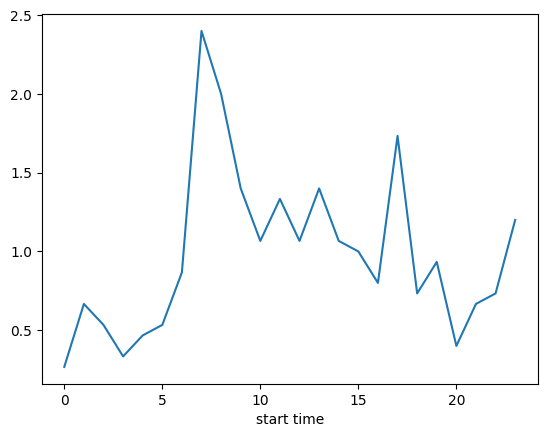

In [ ]:
grouped_id=df_xlsx.groupby('location(latitude/lontitude)')
i=0
for id,df_id in grouped_id:
  #print(id)
  (df_id.groupby([df_id["start time"].dt.hour])["start time"].count()/15).plot()
  i+=1
  break
  if i>=1000:
    break


In [ ]:
dataset_dic=np.load("./TelecomDataset/dataset_dic.npy",allow_pickle=True)

In [ ]:
dataset_dic=delete_overlaps_dataset(dataset_dic)

In [ ]:
dataset_dic, list_id = convervt_id_to_idx(dataset_dic)

In [ ]:
dic_station, list_station=get_dic_station(dataset_dic)

In [ ]:
dataset_dic=add_class(dataset_dic,dic_station)

In [ ]:
idx=2
start_times=dataset_dic[idx]["start time"]
end_times=dataset_dic[idx]["end time"]
nb_time_step_connections=((end_times-start_times).astype('timedelta64[m]')//15)
nb_time_step_btwn_connections=((end_times[1:]-start_times[:-1]).astype('timedelta64[m]')//15)

In [ ]:
print(nb_time_step_connections,nb_time_step_btwn_connections)

In [ ]:
mean=get_mean_connect_time(dataset_dic)

In [ ]:
print((dataset_dic[2]['end time'][0]-dataset_dic[2]['start time'][0]).astype('timedelta64[m]'))


22 minutes


In [ ]:
import numpy as np
np.arange(100).reshape(10,10).reshape(-1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
def blank_name(dataset_dic,idx)
    start_times=dataset_dic[idx]["start time"]
    end_times=dataset_dic[idx]["end time"]
    nb_time_step_connections=((end_times-start_times).astype('timedelta64[m]')//15).int()
    nb_time_step_btwn_connections=((end_times[1:]-start_times[:-1]).astype('timedelta64[m]')//15).int()
    repmat(


In [ ]:

class TimeSeriesDataset(Dataset):
    """
    PyTorch Dataset for the time series data.
    """

    def __init__(self, dataset_dic, input_sequence_len, output_size=1, nan_started=0, nan_stopped=0, missing_indices=np.array([])):
        self.data = dataset_dic
        self.input_sequence_len = input_sequence_len
        self.output_size = output_size
        self.nan_started = nan_started
        self.missing_data_len = nan_stopped - nan_started
        self.missing_indices = missing_indices

    def __len__(self):
        return len(self.data) - 2*self.input_sequence_len - 2*self.output_size - self.missing_data_len

    def __getitem__(self, idx):
        self.data =
        dic_idx= self.data[idx]
        =dic_idx['start time']
        stop_sequence_idx = start_idx + self.input_sequence_len
        stop_target_idx = stop_sequence_idx + self.output_size
        # If considered sequence intersects with the missing value list [11122, .... ,11133]
        # jump to 11134 index
        if np.intersect1d(np.arange(start_idx, stop_target_idx), self.missing_indices).size > 0:
          start_idx = self.missing_indices[-1] + 1

        # Avoid the missing data range
        if stop_target_idx >= self.nan_started :
            start_idx += self.missing_data_len + self.input_sequence_len + self.output_size
            stop_sequence_idx = start_idx + self.input_sequence_len
            stop_target_idx = stop_sequence_idx + self.output_size
        # Extracting a sequence of data
        # YOUR CODE HERE
        assert sequence.shape[0] == self.input_sequence_len
        assert target.shape[0] == self.output_size
        return {'sequence': torch.Tensor(sequence), 'target': torch.Tensor(target)}

NameError: ignored

In [ ]:
nb=0
nb2=0
nb3=0
nb4=0
for id in dataset_dic:
  dic_id=dataset_dic[id]
  startarray=dic_id['start time']
  endarray=dic_id['end time']
  lattitude_array=dic_id['latitude']
  for i in range(len(startarray)-1):
    if startarray[i]>endarray[i]:
      nb4+=0
      print("element :"+str(i)+" of id: "+id)
    if startarray[i+1]<endarray[i]:
      nb+=1
    else:
      nb2+=1
    if startarray[i+1]<endarray[i] and lattitude_array[i]!=lattitude_array[i+1]:
      nb3+=1
    if startarray[i+1]<startarray[i]:
      nb+=0
      print("not sorted")
print(nb,nb2,nb3,nb4)


0 6943182 0 0


KeyError: ignored

In [ ]:
nb4

0

In [ ]:
import numpy as np
df=df.loc[np.isnan(df['latitude'])==False]
print(df)

df['month'] = df["start time"].dt.month
df['day'] = df["start time"].dt.day
df['hour'] = df["start time"].dt.hour
df['minute'] = df["start time"].dt.minute
df['second'] = df["start time"].dt.second
df['year'] = df["start time"].dt.year

df_encoded = df

df_encoded['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df_encoded['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df_encoded['day_sin'] = np.sin(2 * np.pi * df['hour'] / 31)
df_encoded['day_cos'] = np.cos(2 * np.pi * df['hour'] / 31)

df_encoded['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df_encoded['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df_encoded['minute_sin'] = np.sin(2 * np.pi * df['hour'] / 60)
df_encoded['minute_cos'] = np.cos(2 * np.pi * df['hour'] / 60)

df_encoded['second_sin'] = np.sin(2 * np.pi * df['hour'] / 60)
df_encoded['second_cos'] = np.cos(2 * np.pi * df['hour'] / 60)

# Normalise the temperatures into a range of [0, 1],
# to ensure that all input features are on a similar scale
min_latitude = df_encoded['latitude'].min()
max_latitude = df_encoded['latitude'].max()
df_encoded['latitude'] = (df_encoded['latitude'] - min_latitude) / (max_latitude - min_latitude)

min_latitude = df_encoded['longitude'].min()
max_latitude = df_encoded['longitude'].max()
df_encoded['longitude'] = (df_encoded['longitude'] - min_latitude) / (max_latitude - min_latitude)

# Remove unused columns
columns_to_drop = ['year','month','hour','second','minute','date']
df_encoded = df_encoded.drop(columns=columns_to_drop, axis=1)
df_encoded

        month  date          start time            end time   latitude  \
205        10    16 2014-10-16 11:44:35 2014-10-16 11:53:03  31.246946   
206        10    16 2014-10-16 12:08:07 2014-10-16 12:18:56  31.246946   
207        10    16 2014-10-16 08:59:32 2014-10-16 11:00:51  31.246946   
208        10    16 2014-10-16 14:29:49 2014-10-16 14:43:32  31.246946   
209        10    16 2014-10-16 16:08:41 2014-10-16 16:11:17  31.246946   
...       ...   ...                 ...                 ...        ...   
575569     10    31 2014-10-31 14:57:37 2014-10-31 15:01:11  31.087196   
575570     10    31 2014-10-31 14:46:40 2014-10-31 14:48:38  31.087196   
575571     10    31 2014-10-31 15:12:59 2014-10-31 15:14:27  31.087196   
575572     10    31 2014-10-31 16:59:06 2014-10-31 17:00:30  31.087196   
575573     10    31 2014-10-31 15:17:47 2014-10-31 15:19:46  31.087196   

        longitude                           user id  day  hour  minute  ...  \
205      0.654516  b6f11a26170aa

,start time,end time,latitude,longitude,user id,day,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,latitute
205,2014-10-16 11:44:35,2014-10-16 11:53:03,0.359689,0.654516,b6f11a26170aabb49062f79b03818bf2,16,-0.866025,0.5,0.790776,-0.612106,2.588190e-01,-0.965926,0.913545,4.067366e-01,0.913545,4.067366e-01,0.359689
206,2014-10-16 12:08:07,2014-10-16 12:18:56,0.359689,0.654516,b6f11a26170aabb49062f79b03818bf2,16,-0.866025,0.5,0.651372,-0.758758,1.224647e-16,-1.000000,0.951057,3.090170e-01,0.951057,3.090170e-01,0.359689
207,2014-10-16 08:59:32,2014-10-16 11:00:51,0.359689,0.654516,c150c622280f1d6e32dd45e7c59ed751,16,-0.866025,0.5,0.998717,-0.050649,8.660254e-01,-0.500000,0.743145,6.691306e-01,0.743145,6.691306e-01,0.359689
208,2014-10-16 14:29:49,2014-10-16 14:43:32,0.359689,0.654516,b6f11a26170aabb49062f79b03818bf2,16,-0.866025,0.5,0.299363,-0.954139,-5.000000e-01,-0.866025,0.994522,1.045285e-01,0.994522,1.045285e-01,0.359689
209,2014-10-16 16:08:41,2014-10-16 16:11:17,0.359689,0.654516,b6f11a26170aabb49062f79b03818bf2,16,-0.866025,0.5,-0.101168,-0.994869,-8.660254e-01,-0.500000,0.994522,-1.045285e-01,0.994522,-1.045285e-01,0.359689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575569,2014-10-31 14:57:37,2014-10-31 15:01:11,0.353103,0.654231,ec4591ee193aa81f11e60f1962d472df,31,-0.866025,0.5,0.299363,-0.954139,-5.000000e-01,-0.866025,0.994522,1.045285e-01,0.994522,1.045285e-01,0.353103
575570,2014-10-31 14:46:40,2014-10-31 14:48:38,0.353103,0.654231,ec4591ee193aa81f11e60f1962d472df,31,-0.866025,0.5,0.299363,-0.954139,-5.000000e-01,-0.866025,0.994522,1.045285e-01,0.994522,1.045285e-01,0.353103
575571,2014-10-31 15:12:59,2014-10-31 15:14:27,0.353103,0.654231,ec4591ee193aa81f11e60f1962d472df,31,-0.866025,0.5,0.101168,-0.994869,-7.071068e-01,-0.707107,1.000000,2.832769e-16,1.000000,2.832769e-16,0.353103
575572,2014-10-31 16:59:06,2014-10-31 17:00:30,0.353103,0.654231,ec4591ee193aa81f11e60f1962d472df,31,-0.866025,0.5,-0.101168,-0.994869,-8.660254e-01,-0.500000,0.994522,-1.045285e-01,0.994522,-1.045285e-01,0.353103


In [ ]:
import numpy as np
np.float64("Nan")

nan

In [ ]:
df.loc[np.isnan(df['latitude'])==False]

,month,date,start time,end time,latitude,longitude,user id
205,201410,16,2014-10-16 11:44:35,2014-10-16 11:53:03,31.246946,121.513919,b6f11a26170aabb49062f79b03818bf2
206,201410,16,2014-10-16 12:08:07,2014-10-16 12:18:56,31.246946,121.513919,b6f11a26170aabb49062f79b03818bf2
207,201410,16,2014-10-16 08:59:32,2014-10-16 11:00:51,31.246946,121.513919,c150c622280f1d6e32dd45e7c59ed751
208,201410,16,2014-10-16 14:29:49,2014-10-16 14:43:32,31.246946,121.513919,b6f11a26170aabb49062f79b03818bf2
209,201410,16,2014-10-16 16:08:41,2014-10-16 16:11:17,31.246946,121.513919,b6f11a26170aabb49062f79b03818bf2
...,...,...,...,...,...,...,...
575569,201410,31,2014-10-31 14:57:37,2014-10-31 15:01:11,31.087196,121.505435,ec4591ee193aa81f11e60f1962d472df
575570,201410,31,2014-10-31 14:46:40,2014-10-31 14:48:38,31.087196,121.505435,ec4591ee193aa81f11e60f1962d472df
575571,201410,31,2014-10-31 15:12:59,2014-10-31 15:14:27,31.087196,121.505435,ec4591ee193aa81f11e60f1962d472df
575572,201410,31,2014-10-31 16:59:06,2014-10-31 17:00:30,31.087196,121.505435,ec4591ee193aa81f11e60f1962d472df


#Decision tree classifier

In [14]:
#Get inputs and outputs from list_users
inputs=[]
pos_id_targets=[]
pos_ids=[]
for user in list_users:
  inputs.append(user["input"])
  pos_id_targets.append(user["pos_id_target"])
  pos_ids.append(user["pos_id"])
print(inputs[0].shape,pos_id_targets[0].shape,pos_ids[0].shape)

torch.Size([14, 12]) torch.Size([14]) torch.Size([14])


In [15]:
inputs_with_pos_id=[]
for input,pos_id in zip(inputs,pos_ids):
  inputs_with_pos_id.append(torch.cat([input,pos_id.unsqueeze(1)],dim=1))


In [16]:
# print(inputs[0], pos_ids[0], inputs_with_pos_id[0])
# print(inputs[0], pos_id_targets[0])

In [23]:
inputs_with_pos_id=[]
for input,pos_id in zip(inputs,pos_ids):
  inputs_with_pos_id.append(torch.cat([input,pos_id.unsqueeze(1)],dim=1))

#Create a dictionary with the number of data for each class
class_count=dict(zip(range(len(vocab)+1),[0]*(len(vocab)+1)))
print(max(pos_id))
print(len(class_count))
for pos_id in pos_ids:
  for id in pos_id:
    class_count[id.item()]+=1

tensor(2771)
2772
max number of connections for each class 41463 2771
min number of connections for each class 0 9


In [35]:
print(count)

604857


In [34]:
#print data with last column as 2771
for d in inputs_with_pos_id:
  if d[-1]==2771:
    print(d)
    break

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

max number of connections for each class 41463 2771
min number of connections for each class 0 9


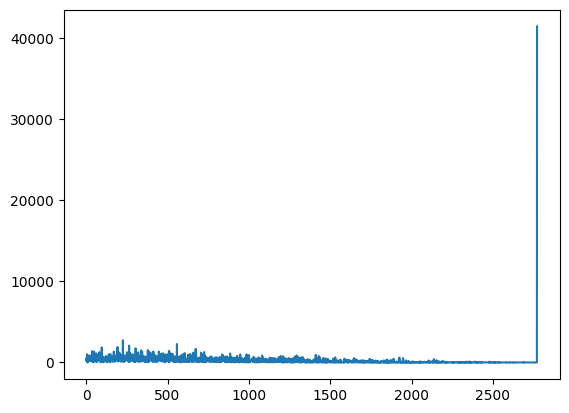

In [25]:
#See the tendency of the number of connections for each class
print("max number of connections for each class"
      ,max(class_count.values())
      ,max(class_count,key=class_count.get))
print("min number of connections for each class"
      ,min(class_count.values())
      ,min(class_count,key=class_count.get))

plt.plot(list(class_count.values()))
plt.show()

In [17]:
#Split the data into training and testing sets
#Get the inputs and targets
inputs = torch.cat(inputs_with_pos_id,dim=0)
pos_id_targets = torch.cat(pos_id_targets,dim=0)

In [ ]:
#Use the model to predict the next position
#Decision tree to predict the next position
# import numpy as np
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split
# from sklearn import metrics
# from sklearn import preprocessing
# from sklearn import tree
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import cross_val_score


# #Convert the data to numpy arrays
# # inputs = inputs.cpu().numpy()
# # pos_id_targets = pos_id_targets.cpu().numpy()

# #Do cross validation
# X_train, X_test, y_train, y_test = train_test_split(inputs, pos_id_targets, test_size=0.3, random_state=1)

# #Initialize the decision tree classifier
# clf = DecisionTreeClassifier()

# # Define hyperparameters grid for tuning
# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 5, 10, 15, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Perform Grid Search Cross Validation to find the best hyperparameters
# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# #initialize the classifier with the best hyperparameters
# clf = DecisionTreeClassifier(criterion=grid_search.best_params_['criterion'],
#                              max_depth=grid_search.best_params_['max_depth'],
#                              min_samples_split=grid_search.best_params_['min_samples_split'],
#                              min_samples_leaf=grid_search.best_params_['min_samples_leaf'])

# #Train the classifier with cross validation
# clf.fit(X_train, y_train)

# # Evaluate the model using cross-validation
# cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
# print("Cross Validation Scores:", cv_scores)
# print("Mean CV Score:", np.mean(cv_scores))

# #Predict the next position
# y_pred = clf.predict(X_test)

# #Evaluate the model
# print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# #Visualize the decision tree
# import graphviz
# dot_data = tree.export_graphviz(clf, out_file=None,
#                                 feature_names=['x_normalised', 'y_normalised', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos'],
#                                 class_names=str(vocab),
#                                 filled=True, rounded=True,
#                                 special_characters=True)
# graph = graphviz.Source(dot_data)
# graph

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [28]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

#Do cross validation
X_train, X_test, y_train, y_test = train_test_split(inputs, pos_id_targets, test_size=0.3, random_state=1)

#got best decision tree classifier
# 'criterion': ['gini', 'entropy'],
parameters = { 'max_depth': [ 15, 35, 50], 'min_samples_split': [30, 50, 100], 'splitter':['best', 'random']}
best_score = -1
# for criterion in parameters['criterion']:
criterion = 'gini'
for max_depth in parameters['max_depth']:
  for min_samples_split in parameters['min_samples_split']:
    for splitter in parameters['splitter']:
      clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, splitter=splitter)
      clf.fit(X_train, y_train)
      score = clf.score(X_test, y_test)
      if score > best_score:
        best_score = score
        best_parameters = {'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'splitter':splitter}

In [33]:
print("best score: ",best_score)
print(best_parameters)
cross_score = cross_val_score(clf, X_train, y_train, cv=5)
print("cross score: ",cross_score)

best score:  0.6232902379614015
{'criterion': 'gini', 'max_depth': 50, 'min_samples_split': 100, 'splitter': 'random'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


cross score:  [0.62394898 0.59696504 0.61921351 0.61924894 0.61977586]


In [30]:
clf = tree.DecisionTreeClassifier(max_depth=best_parameters['max_depth'], min_samples_split=best_parameters['min_samples_split'], splitter=best_parameters['splitter'])
clf = clf.fit(X_train, y_train)


In [31]:
#Predict the next position
y_pred = clf.predict(X_test)

#Evaluate the model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6241003427790452


In [ ]:
#Visualize the decision tree
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=['x_normalised', 'y_normalised', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos', 'pos_id'],
                                class_names=str(vocab),
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph